In [1]:
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('data.csv',error_bad_lines = False, warn_bad_lines=False)

In [4]:
df.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


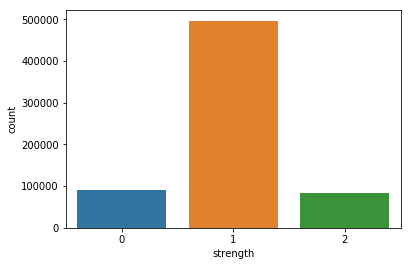

In [5]:
sns.countplot(df['strength'])

In [14]:
df['char_count'] = df['password'].str.len() #Number of characters in password
df['numerics'] = df['password'].apply(lambda x: len([str(x) for x in str(x) if x.isdigit()])) #No. of numerals in password
df['alpha'] = df['password'].apply(lambda x: len([x for x in str(x) if x.isalpha()])) #No. of alphabets in password

vowels = ['a', 'e', 'i', 'o', 'u']
#To check if the password is an actual english word or name, I extracted the number of vowels and consonants in the text
#The basic idea is: The more the consonants, less meaning the password makes
df['vowels'] = df['password'].apply(lambda x: len([x for x in str(x) if x in vowels]))
df['consonants'] = df['password'].apply(lambda x: len([x for x in str(x) if x not in vowels and x.isalpha()]))


In [15]:
df.head()

,password,strength,char_count,numerics,alpha,vowels,consonants
0,kzde5577,1,8.0,4,4,1,3
1,kino3434,1,8.0,4,4,2,2
2,visi7k1yr,1,9.0,2,7,2,5
3,megzy123,1,8.0,3,5,1,4
4,lamborghin1,1,11.0,1,10,3,7


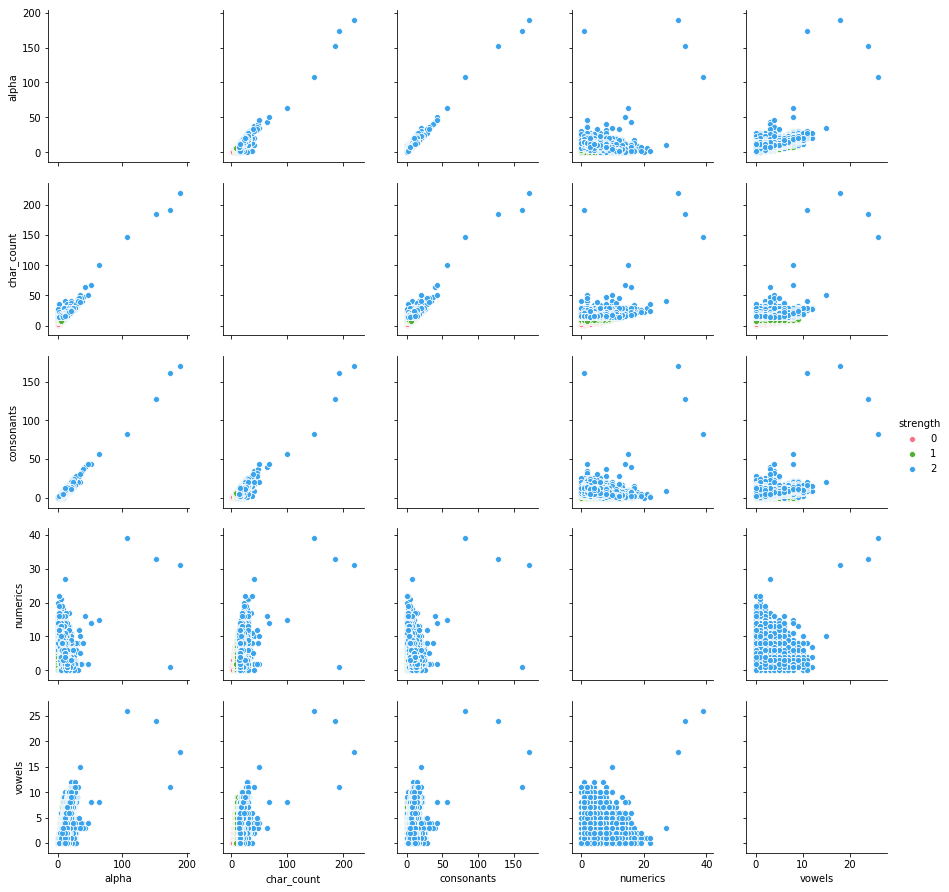

In [18]:
sns.pairplot(data = df, hue = 'strength', vars = df.columns.difference(['password', 'strength']), 
                 diag_kind = {'kde'}, palette = 'husl')

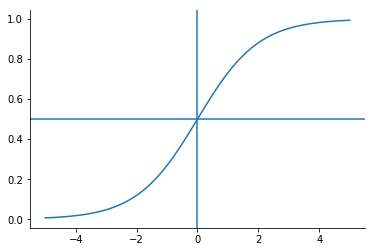

In [20]:
import math
x_values = np.linspace(-5, 5, 100)
y_values = [1 / (1 + math.e**(-x)) for x in x_values]
plt.plot(x_values, y_values)
plt.axhline(.5)
plt.axvline(0)
sns.despine()

In [21]:
1 / (1 + math.e**(-95))

1.0

Below is code that implements everything we discussed. It is vectorized, though, so things are represented as vectors and matricies. It should still be fairly clear what is going on (I hope...if not, please let me know and I can put out a version closer to the math). Also, I didn't implement an intercept (so no  𝛽0 ) feel free to add this if you wish :)

In [22]:
def logistic_func(theta, x):
    return float(1) / (1 + math.e**(-x.dot(theta)))

def log_gradient(theta, x, y):
    first_calc = logistic_func(theta, x) - np.squeeze(y)
    final_calc = first_calc.T.dot(x)
    return final_calc

def cost_func(theta, x, y):
    log_func_v = logistic_func(theta,x)
    y = np.squeeze(y)
    step1 = y * np.log(log_func_v)
    step2 = (1-y) * np.log(1 - log_func_v)
    final = -step1 - step2
    return np.mean(final)

def grad_desc(theta_values, X, y, lr=.001, converge_change=.001):
    #normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    #setup cost iter
    cost_iter = []
    cost = cost_func(theta_values, X, y)
    cost_iter.append([0, cost])
    change_cost = 1
    i = 1
    while(change_cost > converge_change):
        old_cost = cost
        theta_values = theta_values - (lr * log_gradient(theta_values, X, y))
        cost = cost_func(theta_values, X, y)
        cost_iter.append([i, cost])
        change_cost = old_cost - cost
        i+=1
    return theta_values, np.array(cost_iter)

def pred_values(theta, X, hard=True):
    #normalize
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    pred_prob = logistic_func(theta, X)
    pred_value = np.where(pred_prob >= .5, 1, 0)
    if hard:
        return pred_value
    return pred_prob

In [43]:
df.dropna(inplace=True)
X = df.iloc[:,2:]

In [44]:
dummy = df.strength
d = dummy.replace(1,0)
y = d.replace(2,1)

In [49]:
y.value_counts()

0    586502
1     83137
Name: strength, dtype: int64

#### Put it to the test
So here I will use the above code for our example. I initalize our  𝛽  values to all be zero, then run gradient descent to learn the  𝛽  values.

In [45]:
shape = X.shape[1]
betas = np.zeros(shape)
fitted_values, cost_iter = grad_desc(betas, X, y)
print(fitted_values)

char_count    175.146406
numerics       -3.379669
alpha         155.123504
vowels        -20.672881
consonants    170.519799
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


Now let's make some predictions (Note: since we are returning a probability, if the probability is greater than or equal to 50% then I assign the value to strong - or a value of 1):

In [46]:
predicted_y = pred_values(fitted_values, X)
predicted_y

array([0, 0, 0, ..., 1, 0, 0])

In [48]:
#And let's see how accurate we are:
np.sum(y == predicted_y)
#it gives 76% accuracy

510693

In [52]:
#Lastly, another nice check is to see how well a packaged version of the algorithm does:
from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(X, y)
sum(y == logreg.predict(X))
#99.99% accuracy

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


669607

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = linear_model.LogisticRegression(penalty='l2')
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
from sklearn.metrics import accuracy_score

print("Train acc: {}".format(accuracy_score(y_train, train_predictions)))
print("Test acc: {}".format(accuracy_score(y_test, test_predictions)))

Train acc: 0.9999398205314516
Test acc: 0.9999366461369982


In [58]:
pd.Series(y).value_counts(normalize=True)

0    0.875848
1    0.124152
Name: strength, dtype: float64

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, test_predictions)

array([[193478,     14],
       [     0,  27489]], dtype=int64)

In [61]:
from sklearn.metrics import precision_recall_fscore_support
print("Train:")
print(precision_recall_fscore_support(y_train, train_predictions))
print("Test:")
print(precision_recall_fscore_support(y_test, test_predictions))

Train:
(array([1.        , 0.99951504]), array([0.9999313, 1.       ]), array([0.99996565, 0.99975746]), array([393010,  55648], dtype=int64))
Test:
(array([1.        , 0.99949096]), array([0.99992765, 1.        ]), array([0.99996382, 0.99974542]), array([193492,  27489], dtype=int64))


In [62]:
train_prediction_probabilities = clf.predict_proba(X_train)
test_prediction_probabilities = clf.predict_proba(X_test)

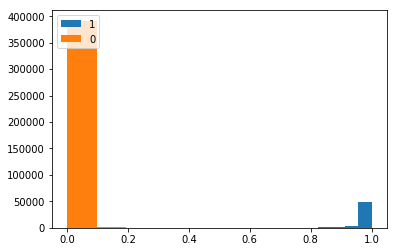

In [63]:
train_probs_for_actual_1 = [train_prediction_probabilities[i][1] for i, truth in enumerate(y_train)
                         if truth == 1]
train_probs_for_actual_0 = [train_prediction_probabilities[i][1] for i, truth in enumerate(y_train)
                         if truth == 0]
plt.hist(train_probs_for_actual_1, label='1')
plt.hist(train_probs_for_actual_0, label='0')
plt.legend(loc='upper left')

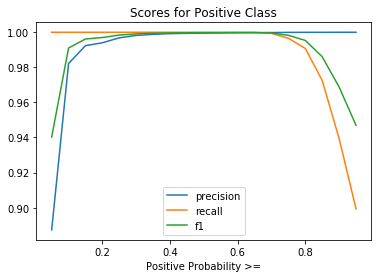

In [64]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precisions, recalls, f1s = [], [], []
cutoffs = np.arange(0.05, 1, 0.05)
for cutoff in cutoffs:
    binary_test_predictions = [x[1] >= cutoff for x in test_prediction_probabilities]
    p, r, f1, s = precision_recall_fscore_support(y_test, binary_test_predictions)
    precisions.append(p[1])
    recalls.append(r[1])
    f1s.append(f1[1])
    
plt.plot(cutoffs, precisions, label='precision')
plt.plot(cutoffs, recalls, label='recall')
plt.plot(cutoffs, f1s, label='f1')
plt.xlabel("Positive Probability >=")
plt.title("Scores for Positive Class")
plt.legend()

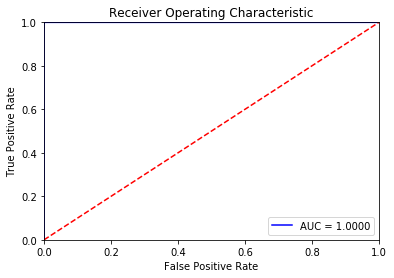

In [65]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, test_prediction_probabilities[:,1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [77]:
coefficients = pd.DataFrame({"Feature":X.columns,"Coefficients":np.transpose(clf.coef_[0])})

In [72]:
np.exp(4.994)

147.52534624995593

In [78]:
coefficients

,Feature,Coefficients
0,char_count,4.994563
1,numerics,-0.653701
2,alpha,-0.434567
3,vowels,-0.450078
4,consonants,0.015511
